# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Lets investigate and try to understand each dataset

#### Dataset 1 - Portfolio

In [2]:
portfolio.sort_values('offer_type')

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


* There are 10 offers
* There are 4 channels - email, mobile, social and web.

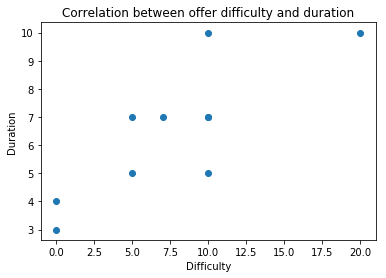

In [3]:
# plt.figure(figsize=(20,10))
plt.scatter(portfolio.difficulty, portfolio.duration);
plt.title('Correlation between offer difficulty and duration');
plt.xlabel('Difficulty');
plt.ylabel('Duration');

There seems to be some sort of positive correlation between offer difficulty and duration of offer

#### Dataset 2 - Profile

In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Here we have id for customer which is unique key and then we have demographic information for customer like age, when it became member with starbucks, gender and income.

Let's look at more details of the dataset

In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


There are 2175 records (17000-14825) for which gender and income data is missing. As informed earlier, age is 118 where age information is missing.

Lets first try to assess if income and gender data is also missing for same set of customers.

Lets calculate for how many records age is 118.

In [6]:
len(profile.loc[profile.age == 118])

2175

So age is 118 for 2175 records which is fine.

Lets check gender and income value where age is 118.

In [7]:
profile.loc[profile.age == 118].gender.unique()

array([None], dtype=object)

In [8]:
profile.loc[profile.age == 118].income.unique()

array([ nan])

So we can see that for 2175 customers age, income and gender data is missing.

We can think of removing these customers beacuse all demographic information is missing for these customers.

Since all demographics is missing for 2175 customers let's create a separete  subset of profile dataset by removing those customers.

In [9]:
profile_comp = profile.loc[profile.age != 118].reset_index()

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
profile_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 6 columns):
index               14825 non-null int64
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 695.0+ KB


Creating subset of data seems fine now. Let's move to analysing and understanding each demograhic data available.

###### Demopgraphic 1: became_member_on

Let's change datatype for became_member_on column

In [12]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

Lets extract year of became_member_on to see if this would be a useful demographic information or not

In [13]:
profile['became_member_on_year'] = pd.DatetimeIndex(profile['became_member_on']).year

In [14]:
profile.became_member_on_year.value_counts()

2017    6469
2018    4198
2016    3526
2015    1830
2014     691
2013     286
Name: became_member_on_year, dtype: int64

It does not seems to be very valuable information as we don't have exact date at which campaign runs. 

In case we want to have another demographic of customer which represent how long customer has been associated with Starbucks, we can take a reference with respect from customer who joined at last. Let's implement into our code.

In [15]:
# Pulling max date
max_date = profile.became_member_on.max()

# Calculating customer association date
profile['cust_assoc_days'] = max_date - profile.became_member_on

# Converting timedetla series into days represented by integer
profile['cust_assoc_days'] = profile['cust_assoc_days'].dt.days

In [16]:
# Checking how data looks like
profile.head()

,age,became_member_on,gender,id,income,became_member_on_year,cust_assoc_days
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,529
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,376
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,14
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,443
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,356


Customer assocation days looks fine now.

Lets also look at this new columns distribution with both complete dataset and filtered dataset with no missing data

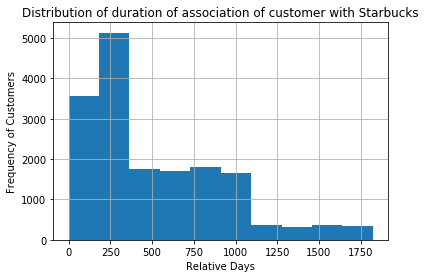

In [17]:
# With complete dataset
profile.cust_assoc_days.hist();
plt.title('Distribution of duration of association of customer with Starbucks');
plt.xlabel('Relative Days');
plt.ylabel('Frequency of Customers');

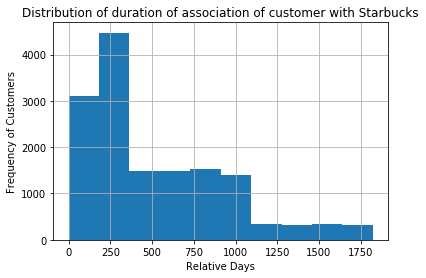

In [18]:
profile_comp = profile.loc[profile.age != 118].reset_index()

# With filtered dataset
profile_comp.cust_assoc_days.hist();
plt.title('Distribution of duration of association of customer with Starbucks');
plt.xlabel('Relative Days');
plt.ylabel('Frequency of Customers');

in both dataset, association duration is highly skewed to right.

###### Demopgraphic 2: Gender

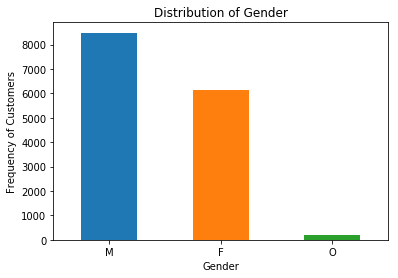

In [19]:
# Plotting Bar Graph
plt.title('Distribution of Gender');
plt.xlabel('Gender');
plt.ylabel('Frequency of Customers');

profile.gender.value_counts().plot.bar(rot=0);

In [20]:
# In terms of %age for entire dataset
profile.gender.value_counts()*100 / len(profile.gender)

M    49.905882
F    36.052941
O     1.247059
Name: gender, dtype: float64

In [21]:
# In terms of %age for dataset after removing records with missing information
profile_comp.gender.value_counts()*100 / len(profile_comp.gender)

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

%age of males is greater than female. It would be interesting to see spending pattern for both gender.

###### Demopgraphic 3: Income

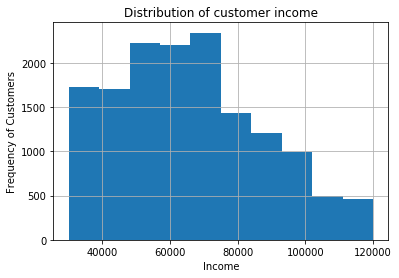

In [22]:
profile_comp.income.hist();
plt.title('Distribution of customer income');
plt.xlabel('Income');
plt.ylabel('Frequency of Customers');

income seems to be right skewed which seems quite acceptable as high income people are expected to be less as compated to income on lower end. This means it would be fair to assume that customer selected for campaign trial represent actual world population.

###### Demopgraphic 4: age

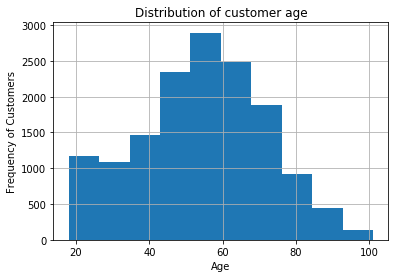

In [23]:
profile_comp.age.hist();
plt.title('Distribution of customer age');
plt.xlabel('Age');
plt.ylabel('Frequency of Customers');

Some observations

* Distribution is slightly skewed to the right.
* We have quite diverse customer base with age varying from 18 to 101.
* Age seems to be normally distributed with peak happening around 50-70.

##### I have completed the analysis of dataset - profle and have few points to summarize.

* There are total of 17000 customers from which age, income and gender demographics is missing for 2175 customers
* I created a subset with those 2175 customers removed (name of DataFrame - profile_comp)
* There are 4 demographics that are availble to us now - age, gender, income and duration of association of customer with Starbucks

#### Dataset 3 - Transcript

In [24]:
pd.set_option('display.max_colwidth', -1)
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


Let's analyse each column 1 by 1

##### Column 1 - person

Lets see how many customers have been covered in transactions

In [26]:
transcript.person.nunique()

17000

Count is coming out to be 17000 persons which means transcript covers every person in DataFrame - 'profile'

##### Column 2 - event

In [27]:
transcript.event.value_counts()

transaction        138953
offer received     76277 
offer viewed       57725 
offer completed    33579 
Name: event, dtype: int64

There are 4 type of events

* Transactions
* offer received
* offer viewed
* offer completed

##### Column 3 - value

This column contain details of event. Lets see what this column contain for different value of events

In [28]:
transcript['value'].loc[transcript.event == 'transaction'].head()

12654    {'amount': 0.8300000000000001}
12657    {'amount': 34.56}             
12659    {'amount': 13.23}             
12670    {'amount': 19.51}             
12671    {'amount': 18.97}             
Name: value, dtype: object

In [29]:
transcript['value'].loc[transcript.event == 'offer received'].head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [30]:
transcript['value'].loc[transcript.event == 'offer viewed'].head()

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object

In [31]:
pd.set_option('display.max_colwidth', -1)
transcript['value'].loc[transcript.event == 'offer completed'].head()

12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2} 
12672    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2} 
12679    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5} 
12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}
12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}
Name: value, dtype: object

Value column if of type 'dict' and contain amount for transaction & offer id for offer related events (either received, viewed or completed)

Offer Completed Events have one more information in value column which is reward

##### Column 4 - time

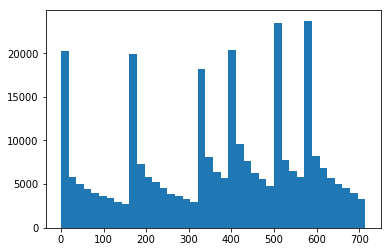

In [32]:
plt.hist(transcript.time, bins=40);

Data is right skewed with multiple peaks. It seems peek is observed at time some offers are send in bulk which create concentrated records with same timing.

Lets look at distbution for each type of transaction

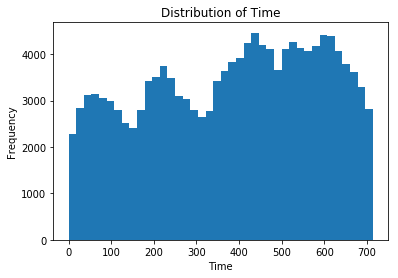

In [33]:
plt.hist(transcript.loc[transcript.event == 'transaction'].time, bins=40);
plt.title('Distribution of Time');
plt.xlabel('Time');
plt.ylabel('Frequency');

For now it does not show any meaningful insight. Lets look at other event.

Plotting for event - 'offer received'

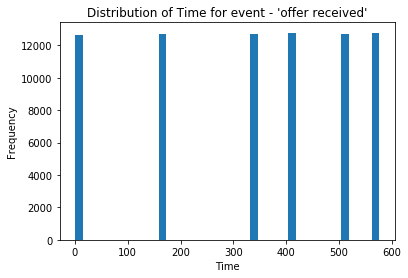

In [34]:
plt.hist(transcript.loc[transcript.event == 'offer received'].time, bins=40);
plt.title("Distribution of Time for event - 'offer received'");
plt.xlabel('Time');
plt.ylabel('Frequency');

This shows that offer were sent to customer on 6 instances only represented by 6 bars. Peak size is close to 12000.

Plotting for event - 'offer viewed'

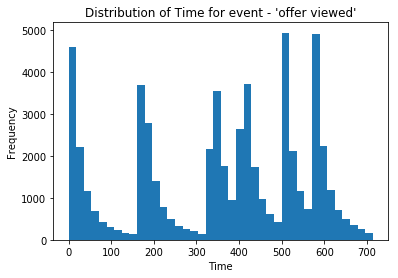

In [35]:
plt.hist(transcript.loc[transcript.event == 'offer viewed'].time, bins=40);
plt.title("Distribution of Time for event - 'offer viewed'");
plt.xlabel('Time');
plt.ylabel('Frequency');

It is highest peaks close to time offer was received by customers. Peak size is between 3500 to 5000 which is lower than those of event 'offer received'

Plotting for event - 'offer completed'

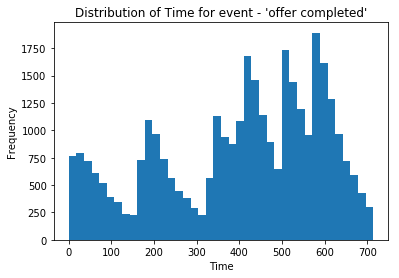

In [36]:
plt.hist(transcript.loc[transcript.event == 'offer completed'].time, bins=40);
plt.title("Distribution of Time for event - 'offer completed'");
plt.xlabel('Time');
plt.ylabel('Frequency');

Peak size is shorter than those of event 'offer viewed' and subsequent peaks are higher which probably means that with time probability of success increases.

Now let's look at all stages simultaneaously

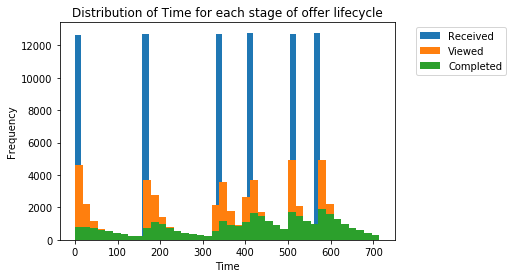

In [37]:
# Analyzing distribution of time for life cycle of offer

plt.hist(transcript.loc[transcript.event == 'offer received'].time, bins=40, label='Received');
plt.hist(transcript.loc[transcript.event == 'offer viewed'].time, bins=40, label='Viewed');
plt.hist(transcript.loc[transcript.event == 'offer completed'].time, bins=40, label='Completed');
plt.title('Distribution of Time for each stage of offer lifecycle');
plt.xlabel('Time');
plt.ylabel('Frequency');
plt.legend(loc='best', bbox_to_anchor=(1.05, 1));

At each stage of lifecycle of an offer, peak occer in sequence and peak gets smaller.

* Which means first offer is received by customer which has highest peak (blue)
* Then offer is viewed by less number of customer (orange peak is slightly after blue peak and smaller than blue peak)
* Then offer is completed by even less number of customers (green peak are smaller than orange peak and slightly after orange peak)

Let's see when offer are send to customers.

In [38]:
transcript.loc[transcript.event == 'offer received'].time.value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

Lets see average time for all type of events as well

In [39]:
transcript.groupby('event')['time'].mean()

event
offer completed    401.052801
offer received     332.579519
offer viewed       354.290515
transaction        381.584334
Name: time, dtype: float64

Average time offer related records ('offer completed', 'offer received', 'offer viewed') is in logical order.

* First offer is received
* Then offer is viewed 
* Then offer is completed

#### Analysing customer behaviour by transforming transcript data

Let's divide the transcript data into 2 parts.

* Transactions data
* Offer data

### Data Pre-processing

#### Sub-dataset 1: Transaction Data

In [40]:
# Creating the dataframe
transaction_transcript = transcript.loc[transcript.event == 'transaction'].reset_index()

# Renaming index to ensure we have unique id for each row
transaction_transcript.rename(columns={'index': 'index_tran'}, inplace=True);

In [41]:
transaction_transcript.head()

,index_tran,event,person,time,value
0,12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
1,12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
2,12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
3,12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
4,12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


Since 'value' column contain the transaction amount, lets create new variable to store the amount

Creating New Variable - transaction_amount

In [42]:
# Creating New Variable - transaction_amount
transaction_transcript['transaction_amount'] = [d.get("amount") for d in transaction_transcript.value]

In [43]:
transaction_transcript.head()

,index_tran,event,person,time,value,transaction_amount
0,12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0.83
1,12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},34.56
2,12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},13.23
3,12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},19.51
4,12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},18.97


In [44]:
transaction_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138953 entries, 0 to 138952
Data columns (total 6 columns):
index_tran            138953 non-null int64
event                 138953 non-null object
person                138953 non-null object
time                  138953 non-null int64
value                 138953 non-null object
transaction_amount    138953 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.4+ MB


New Variable - 'value' Created

Now, lets try to understand this newly created dataset.

Let's look at how much customer spend during entire duration of campaign

In [45]:
# Creating DataFrame
cust_spent_dist = transaction_transcript.groupby(['time'])['transaction_amount'].sum().reset_index()

# Printing Max and min amouunt spent in a day
print('Max Amount spend in a day = ','${:,.2f}'.format(max(cust_spent_dist.transaction_amount)))
print('Min Amount spend in a day = ','${:,.2f}'.format(min(cust_spent_dist.transaction_amount)))

Max Amount spend in a day =  $22,461.34
Min Amount spend in a day =  $7,305.57


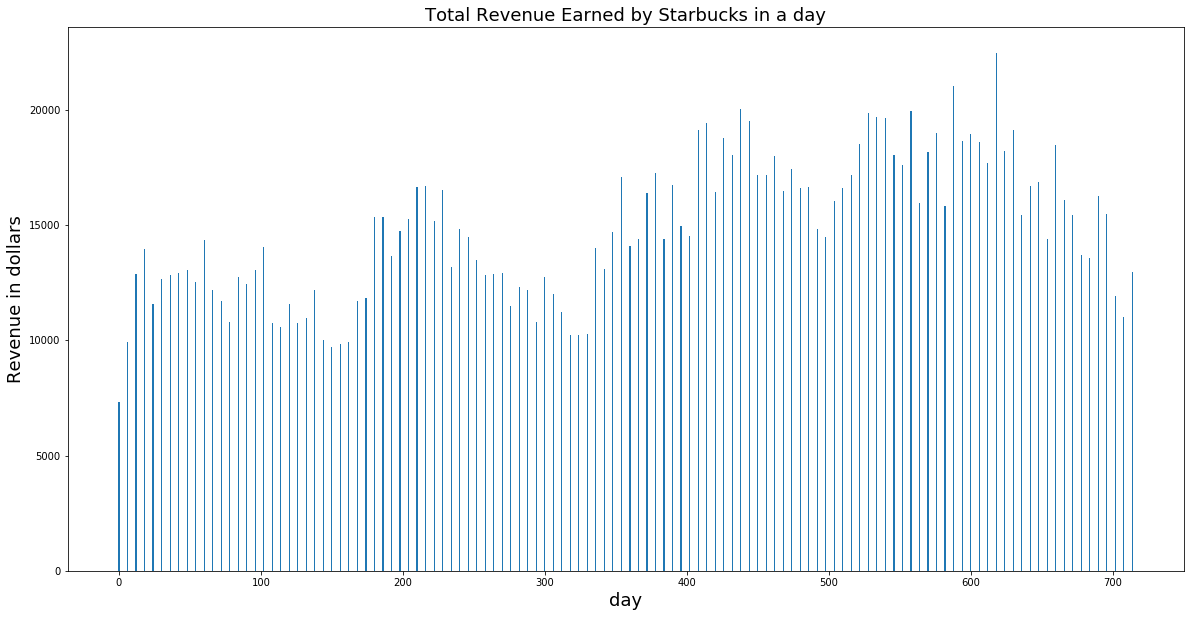

In [46]:
plt.figure(figsize=(20,10));
plt.bar(cust_spent_dist.time, height=cust_spent_dist.transaction_amount);
plt.title('Total Revenue Earned by Starbucks in a day',  fontsize=18);
plt.xlabel('day',  fontsize=18);
plt.ylabel('Revenue in dollars',  fontsize=18);

We can see here that customer spending was higher in later stage of campaign period

To see why customer spending was higher in that period, 

##### Let's look at how many customer do the spending on particular point of time

In [47]:
# Creating Dataframe
cust_count_dist = transaction_transcript.groupby(['time'])['person'].nunique().reset_index()

# Printing the max and min of no of people who do shopping in a day
print('Max People who spend at starbucks in a day = ',max(cust_count_dist.person))
print('Min People who spend at starbucks in a day = ',min(cust_count_dist.person))

Max People who spend at starbucks in a day =  1528
Min People who spend at starbucks in a day =  633


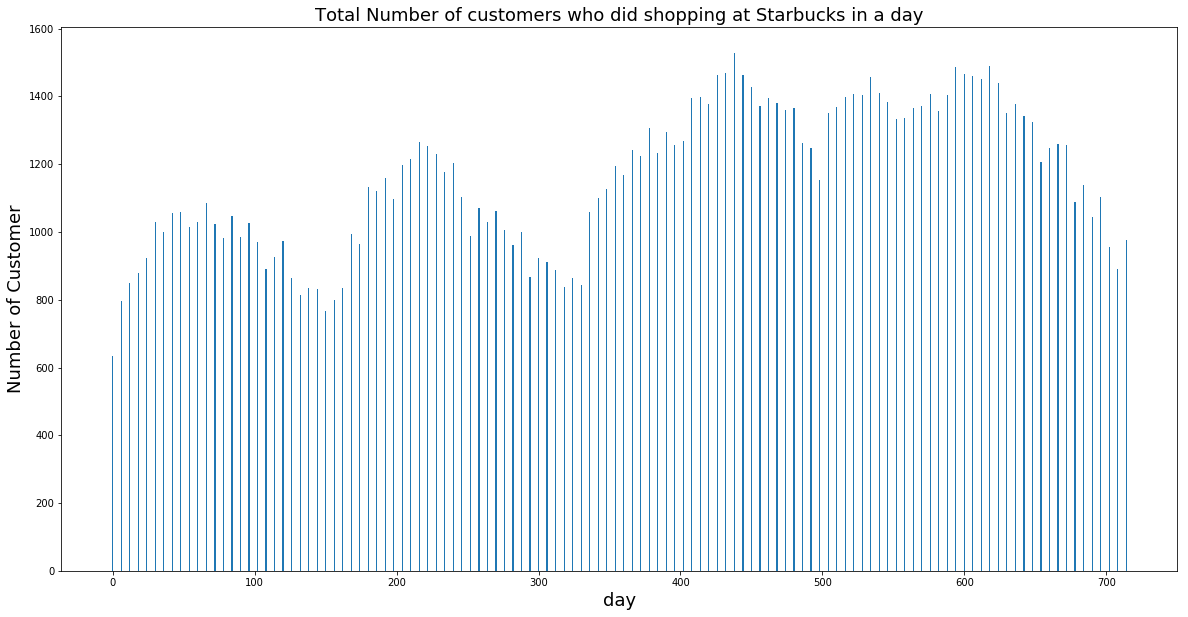

In [48]:
plt.figure(figsize=(20,10));
plt.bar(cust_count_dist.time, height=cust_count_dist.person);
plt.title('Total Number of customers who did shopping at Starbucks in a day',  fontsize=18);
plt.xlabel('day',  fontsize=18);
plt.ylabel('Number of Customer',  fontsize=18);

Here also, we can see that more customers did shopping at Starbucks in later stage of campaign period.

Now let's look at trend of average spending during a day.

In [49]:
# Creating Dataframe
avg_spent = transaction_transcript.groupby(['time'])['transaction_amount'].mean().reset_index(name='avg_spent')

# Printing the max and min of no of people who do shopping in a day
print('Max Average of spending in a day = ',max(avg_spent.avg_spent))
print('Min Average of spending in a day = ',min(avg_spent.avg_spent))

Max Average of spending in a day =  15.883503981797464
Min Average of spending in a day =  10.993088685015302


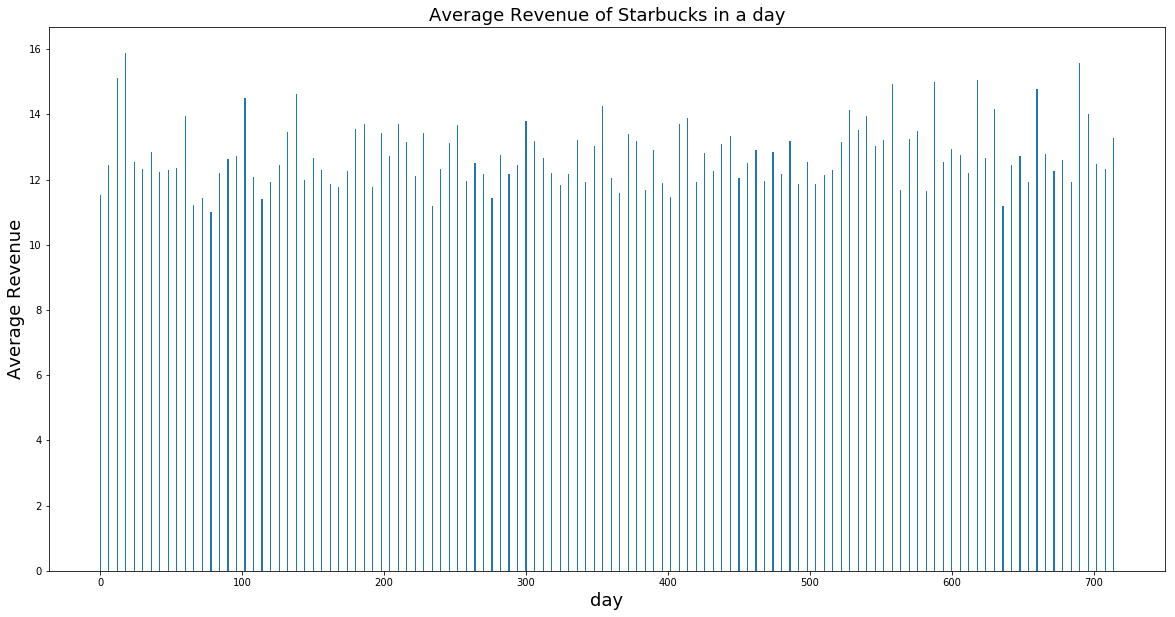

In [50]:
plt.figure(figsize=(20,10));
plt.bar(avg_spent.time, height=avg_spent.avg_spent);
plt.title('Average Revenue of Starbucks in a day',  fontsize=18);
plt.xlabel('day',  fontsize=18);
plt.ylabel('Average Revenue',  fontsize=18);

Trend of average revenue in a day for Starbucks shows a flat trend.

This means that higher spending was offset by more people doing shopping with Starbucks.

Let's try to see if any customer did more than one transaction in a particular day. If that is the case, I would have to consolidate data for each unit of time and person

In [51]:
print('Before consolidation size of dataset', transaction_transcript.shape)
print('Before consolidation, transaction amount', '${:,.2f}'.format(transaction_transcript.transaction_amount.sum()))

# Doing consolidation
print('consolidation happes')

transaction_transcript_cons = transaction_transcript.groupby(['event','person','time'])['transaction_amount'].sum().reset_index()

print('After consolidation size of dataset', transaction_transcript_cons.shape)
print('After consolidation, transaction amount', '${:,.2f}'.format(transaction_transcript_cons.transaction_amount.sum()))

Before consolidation size of dataset (138953, 6)
Before consolidation, transaction amount $1,775,451.97
consolidation happes
After consolidation size of dataset (138953, 4)
After consolidation, transaction amount $1,775,451.97


There is no reduction in length of dataset. We can use 'transaction_transcript' DataFrame

Lets move to another subset of transcript dataset.

#### Sub-dataset 2: Offer Received Data

Preparing the dataframe

In [52]:
# Filter out data where offer was received by customer
offer_received_transcript = transcript.loc[transcript.event == 'offer received'].reset_index()

# Extract Offer Id
offer_received_transcript['offer_id'] = [d.get("offer id") for d in offer_received_transcript.value]

# Merge Offer details (df - portfolio) with filtered data
offer_received_transcript = pd.merge(offer_received_transcript, portfolio, left_on= 'offer_id', right_on='id',how='left')

In [53]:
offer_received_transcript.head()

,index,event,person,time,value,offer_id,channels,difficulty,duration,id,offer_type,reward
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
1,1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
2,2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
3,3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
4,4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


Lets look at each column one by one.

Starting with person, lets check how many customer are there in this dataframe

In [54]:
# Count of unique customers in the campaign
offer_received_transcript.person.nunique()

16994

This means that most of customers were covered whose information we have in profile dataframe

Now, lets look at 'time' column 

In [55]:
offer_received_transcript.time.value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

As seen here and in histogram shown earlier, offer were circulated to customers at some fixed point of time. 

We can see that offer were distributed 6 times during campaign. These timings are 0, 168, 336, 408, 504 and 576.

Now lets see if at each point of offer distribution, was each customer offered with one offer only or multiple offers.

In [56]:
offer_received_transcript.groupby(['person', 'time']).size().reset_index(name = 'Freq')['Freq'].value_counts()

1    76277
Name: Freq, dtype: int64

This means that at one point of time, one customer was offered only one offer and we can fairly assume that customer would be under influence of offer till the time he/she is offered new offer.

Now lets see during entire campaign, how many times customer was offered with an offer.

In [57]:
offer_received_transcript.person.value_counts().reset_index()['person'].value_counts()

5    5931
4    4988
6    3067
3    2325
2    610 
1    73  
Name: person, dtype: int64

Above table shows that only 73 out of 16994 customer received offer only once. 
This shows that majority of customers were offered offers more than once during the campaign.

Most of customer received offer more than once. Most common count is 5, 4 and 6


Now lets look at distribution of how many type of offers that customer received

In [58]:
# Distinct Values of offer type and customer
df_1 = offer_received_transcript.groupby(['person', 'offer_type']).size().reset_index(name='occurance')

# No of unique customers
df_1.person.nunique()

df_2 = df_1.groupby(['person'])['offer_type'].count().reset_index()


df_2['offer_type'].value_counts()

2    8460
3    7515
1    1019
Name: offer_type, dtype: int64

So most of customer were offered more than one type of offers. This is a good sign as we can see how customers behaves to different type of customers.

Let's check if one customer was offered only one product at one point time or more

In [59]:
offer_received_transcript.groupby(['person', 'time']).size().reset_index(name='occurance').occurance.value_counts()

1    76277
Name: occurance, dtype: int64

#### Sub-dataset 3: Offer Viewed Data

In [60]:
# Filter out data where offer was received by customer
offer_viewed_transcript = transcript.loc[transcript.event == 'offer viewed'].reset_index()

# Extract Offer Id
offer_viewed_transcript['offer_id'] = [d.get("offer id") for d in offer_viewed_transcript.value]

# Rename the column time which is present in multiple dataframes
offer_viewed_transcript.rename(columns={'time': 'time_view'}, inplace=True)


# Merge Offer details (df - portfolio) with filtered data
offer_viewed_transcript = pd.merge(offer_viewed_transcript, portfolio, left_on= 'offer_id', right_on='id',how='left')

In [61]:
offer_viewed_transcript.head()

,index,event,person,time_view,value,offer_id,channels,difficulty,duration,id,offer_type,reward
0,12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
1,12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
2,12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
4,12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


Let's look at the time variable distribution

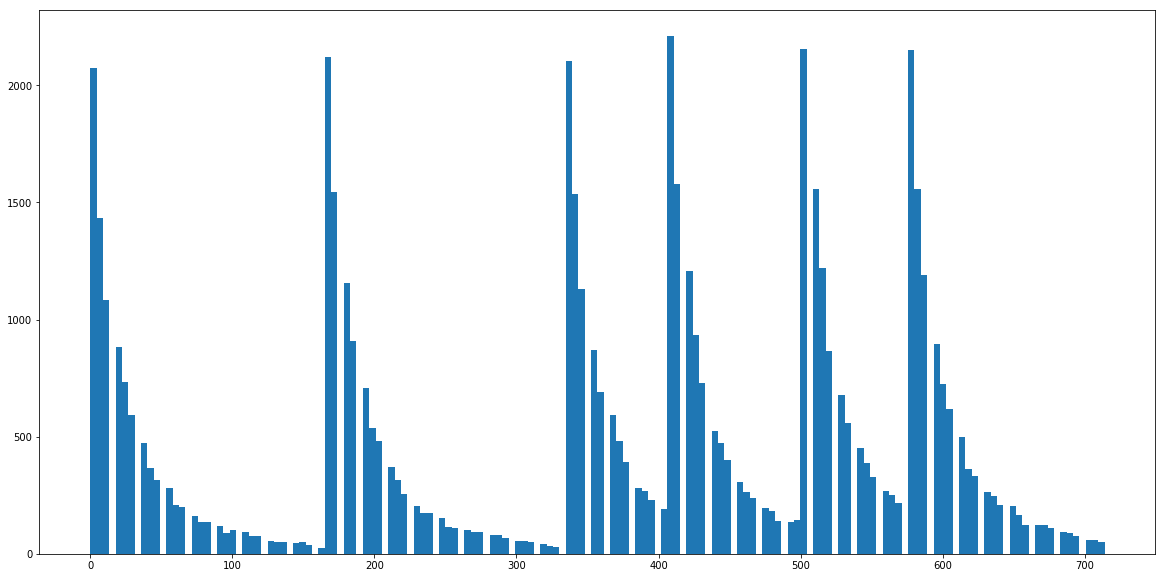

In [62]:
plt.figure(figsize=(20,10))
plt.hist(offer_viewed_transcript.time_view, bins=160);

Let's check if customer viewed more than one offer at any point of time

In [63]:
# Person Time Frequency
person_time_viewed_freq = offer_viewed_transcript.groupby(['person', 'time_view']).size().\
reset_index(name='person_time_viewed_freq')
print('shape of person_time_viewed_freq', person_time_viewed_freq.shape)

print('\t')
# Printing Frequency of person_time_viewed_freq
print('Distribution of person_time_viewed_freq \b')
print(person_time_viewed_freq.person_time_viewed_freq.value_counts())

shape of person_time_viewed_freq (57725, 3)
	
Distribution of person_time_viewed_freq 
1    57725
Name: person_time_viewed_freq, dtype: int64


This means that customer has viewed only 1 order at one point of time.

Let's see how frequency of appearance of person in 'offer viewed' data and compare it with 'offer received' data

In [64]:
# viewed_freq
viewed_freq = offer_viewed_transcript.groupby(['person']).size().reset_index(name='viewed_freq')
print('Before Merging:')
print('shape of viewed_freq', viewed_freq.shape)

# received_freq
received_freq = offer_received_transcript.groupby(['person']).size().reset_index(name='received_freq')
print('shape of received_freq', received_freq.shape)

print('\t')
# Merging 2 datasets
received_viewed_pattern = pd.merge(received_freq, \
                                   viewed_freq, \
                                  left_on='person', \
                                   right_on='person', \
                                   how='left')
print('After Merging:')
print('shape of received_viewed_pattern', received_viewed_pattern.shape) 


# Replace Nan with 0
received_viewed_pattern.viewed_freq.fillna(0, inplace=True)

# Checking if Viewed Freq is greater than received Freq 
received_viewed_pattern['check_flag'] = received_viewed_pattern['viewed_freq'] > received_viewed_pattern['received_freq']
print('\t')
print('No of persons with more offer viewed than received =', sum(received_viewed_pattern.check_flag))

Before Merging:
shape of viewed_freq (16834, 2)
shape of received_freq (16994, 2)
	
After Merging:
shape of received_viewed_pattern (16994, 3)
	
No of persons with more offer viewed than received = 0


This means that no person has viewed more offer than it has received.

Lets see how many customers viewed how many offered from all offers received

In [65]:
received_viewed_pattern['check_flag_2'] = received_viewed_pattern['received_freq'] - received_viewed_pattern['viewed_freq']

print(received_viewed_pattern['check_flag_2'].value_counts());
print(received_viewed_pattern['check_flag_2'].value_counts() * 100 / 17000 );
# print("{0:.0f}%".format(received_viewed_pattern['check_flag_2'].value_counts()*100/17000))

0.0    6366
1.0    5212
2.0    3468
3.0    1459
4.0    423 
5.0    61  
6.0    5   
Name: check_flag_2, dtype: int64
0.0    37.447059
1.0    30.658824
2.0    20.400000
3.0    8.582353 
4.0    2.488235 
5.0    0.358824 
6.0    0.029412 
Name: check_flag_2, dtype: float64


This means that 37% customers viewed all the offers they receieved.

For remaining 62% customers, they missed to see the offer they received atleast once. For such scenario where customer did not view the latest offer they received, it would be assumed that offer had no impact on buying pattern.

Let's link 'offer_received_transcript' data with 'offer_viewed_transcript' to get more insights

In [66]:
# Step 1
# Select max time for each customer
max_time_df = transcript.groupby(['person'])['time'].max().reset_index(name = 'max_time')

# Step 2
# Introduce new column 'time_end' - time at which offer validity ends
# and Change time column name
offer_received_transcript['time_end'] = offer_received_transcript.time + offer_received_transcript.duration
offer_received_transcript.rename(columns={'time': 'time_start'}, inplace=True)

# Step 3
# Add this max date to offer received data
print('Before adding max date, shape = ',offer_received_transcript.shape)
offer_received_transcript_1 = pd.merge(offer_received_transcript, \
                                       max_time_df,
                                       left_on='person',
                                       right_on='person', 
                                       how='left')
print('After adding max date, shape = ',offer_received_transcript_1.shape)


# Step 4
# Add date lead column

offer_received_transcript_2 = offer_received_transcript_1.sort_values(by=['person', 'time_start']).reset_index()
offer_received_transcript_2['time_start_next'] = 0

for i in range(len(offer_received_transcript_2)-1):
    person_now = offer_received_transcript_2.person[i]
    person_next = offer_received_transcript_2.person[i+1]
    
#     In case time_end exceed max_time, max_time should get adjusted
    if offer_received_transcript_2['time_end'][i] > offer_received_transcript_2['max_time'][i]:
        offer_received_transcript_2.iloc[i, offer_received_transcript_2.columns.get_loc('max_time')] = \
        offer_received_transcript_2['time_end'][i] 
    
    if person_now == person_next:
#         offer_received_transcript_2['time_start_next'][i] = offer_received_transcript_2['time_start'][i+1]
        offer_received_transcript_2.iloc[i, offer_received_transcript_2.columns.get_loc('time_start_next')] = \
        offer_received_transcript_2['time_start'][i+1]
    else:
#         offer_received_transcript_2['time_start_next'][i] = offer_received_transcript_2['max_time'][i]
        offer_received_transcript_2.iloc[i, offer_received_transcript_2.columns.get_loc('time_start_next')] = \
        offer_received_transcript_2['max_time'][i] + 1
    

# Step 5
# Since Last column is not taken care by the for loop, it is adjusted manually
    
offer_received_transcript_2.iloc[len(offer_received_transcript_2)-1, 
                                 offer_received_transcript_2.columns.get_loc('time_start_next')] = \
offer_received_transcript_2['max_time'][len(offer_received_transcript_2)-1]

print('After adding lead of time_start, shape = ',offer_received_transcript_2.shape)


# Step 6
# Combine offer_viewed_transcript data
offer_received_transcript_3 = pd.merge(offer_received_transcript_2, 
                                       offer_viewed_transcript, 
                                       how='left', 
                                       on=['person', 'offer_id'], 
                                       suffixes=("_recd", "_view"))
print('After combining offer_viewed_transcript data, shape = ',offer_received_transcript_3.shape)


# Step 7
# Applying filter where view_time is between time at which offer starts and time at which next offer is received by customer
offer_received_transcript_4 = offer_received_transcript_3.query('time_view >= time_start and time_view < time_start_next')
print('After applying filter on time_view , shape = ',offer_received_transcript_4.shape)



Before adding max date, shape =  (76277, 13)
After adding max date, shape =  (76277, 14)
After adding lead of time_start, shape =  (76277, 16)
After combining offer_viewed_transcript data, shape =  (95321, 26)
After applying filter on time_view , shape =  (57725, 26)


Checking if merging has happened correctly or not.

Here I am checking if index of DF - offer_viewed_transcript are present after merging or not

In [67]:
# view_index_orig = offer_viewed_transcript.index.to_series()

view_index_orig = offer_viewed_transcript['index']
print(len(view_index_orig))

view_index_freq_df = offer_received_transcript_4.groupby(['index_view']).size().reset_index(name='freq_of_index_view')
view_index_after_merge = view_index_freq_df.index_view
print(len(view_index_after_merge))

outlier_index = view_index_orig[~view_index_orig.isin(view_index_after_merge)]
print(outlier_index.shape)

57725
57725
(0,)


Here 0 means that all rows have been successfully linked with rows of 'offer_received_transcript'

Merging rows of 'offer_received_transcript' that were not linked with 'offer_viewed_transcript' with merged dataset

In [68]:
# Count should be 18552

# Pulling original Index for received dataframe
review_original_index = offer_received_transcript_2['index']

# Pulling original index when 'offer received transaction' has been linked with 'offer viewed transaction'
review_original_index_after_view_linkage = offer_received_transcript_4['index_recd']

# List of index from rows of 'offer received transaction' which could not be linked with 'offer viewed transaction'
unlinked_index_list = review_original_index[~review_original_index.isin(review_original_index_after_view_linkage)]

# creating dataframe of unlinked received transactions
offer_received_transcript_not_linked_with_viewed_df = offer_received_transcript_2.loc[offer_received_transcript_2['index'].isin(unlinked_index_list.tolist())]

# Changing columns name to match with column name in df containing rows 
# from 'offer received transaction' that has been linked with 'offer viewed transaction'
offer_received_transcript_not_linked_with_viewed_df.rename(columns={'index' : 'index_recd', 
                                                                    'event' : 'event_recd', 
                                                                    'person' : 'person', 
                                                                    'time_start' : 'time_start',
                                                                    'value' : 'value_recd', 
                                                                    'offer_id' : 'offer_id', 
                                                                    'channels' : 'channels_recd', 
                                                                    'difficulty' : 'difficulty_recd', 
                                                                    'duration' : 'duration_recd',
                                                                    'id' : 'id_recd', 
                                                                    'offer_type' : 'offer_type_recd', 
                                                                    'reward' : 'reward_recd'}, 
                                                           inplace=True)

# Merging the linked received transactions with unlinked received transactions
print(offer_received_transcript_4.shape)
print(offer_received_transcript_not_linked_with_viewed_df.shape)


offer_received_viewed_transcript = pd.concat([offer_received_transcript_4, offer_received_transcript_not_linked_with_viewed_df]
                                             , sort=True)

print(offer_received_viewed_transcript.shape)

(57725, 26)
(18552, 16)
(76277, 26)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


#### Sub-dataset 4: Offer Completed Data

In [69]:
# Filter out data where offer was received by customer
offer_completed_transcript = transcript.loc[transcript.event == 'offer completed'].reset_index()

# Extract Offer Id
offer_completed_transcript['offer_id'] = [d.get("offer_id") for d in offer_completed_transcript.value]

# Merge Offer details (df - portfolio) with filtered data
offer_completed_transcript = pd.merge(offer_completed_transcript, portfolio, left_on= 'offer_id', right_on='id',how='left')

# Rename columns appropriately
offer_completed_transcript.rename(columns={'time': 'time_completed'}, inplace=True)
offer_completed_transcript.rename(columns={'index': 'index_completed'}, inplace=True)

Checking duplicate records and cleaning dataset to remove duplicates

In [70]:
duplicate_records = offer_completed_transcript.pivot_table(index = ['person', 
                                                                    'time_completed', 
                                                                    'offer_id'], 
                                                           aggfunc ='size').reset_index(name='duplicate_count')

print('Before data cleansing')
print(duplicate_records.groupby(['duplicate_count']).size())


offer_completed_transcript_deduplicated = offer_completed_transcript.drop_duplicates(subset=['person', 
                                                                                             'time_completed', 
                                                                                             'offer_id'], 
                                                                                     keep='first')

duplicate_records_after = offer_completed_transcript_deduplicated.pivot_table(index = ['person', 
                                                                    'time_completed', 
                                                                    'offer_id'], 
                                                           aggfunc ='size').reset_index(name='duplicate_count')

print('After data cleansing')
print(duplicate_records_after.groupby(['duplicate_count']).size())

Before data cleansing
duplicate_count
1    32786
2    395  
3    1    
dtype: int64
After data cleansing
duplicate_count
1    33182
dtype: int64


Deduplication complete

Now, lets do some quality checking of this new dataset.

Check 1: No of customers covered

In [71]:
offer_completed_transcript.person.nunique()

12774

Lets merge completed data with earlier created dataset - 'offer_received_viewed_transcript'

In [72]:
# Step 1
# Merge the datasets
offer_received_viewed_transcript_1 = pd.merge(offer_received_viewed_transcript, 
                                       offer_completed_transcript_deduplicated, 
                                       how='left', 
                                       on=['person', 'offer_id'], 
                                       suffixes=("", "_comp"))
print('After merging shape of offer_received_viewed_transcript_1', offer_received_viewed_transcript_1.shape)

# Step 2
# Filter the dataset

offer_received_viewed_transcript_2 = offer_received_viewed_transcript_1.\
query('time_completed >= time_start and time_completed < time_start_next')
print('After filtering shape of offer_received_viewed_transcript_2', offer_received_viewed_transcript_2.shape)

After merging shape of offer_received_viewed_transcript_1 (85520, 36)
After filtering shape of offer_received_viewed_transcript_2 (28318, 36)


Data Cleansing

Step 1 - Checking frequency of index from 'offer_received_transcript'

In [73]:
offer_received_viewed_transcript_2.groupby(['index_recd']).size().reset_index(name='freq_of_index_recd').groupby(['freq_of_index_recd']).size().reset_index(name='freq_of_freq_of_index_recd')

,freq_of_index_recd,freq_of_freq_of_index_recd
0,1,28202
1,2,58


In [74]:
offer_received_viewed_transcript_2.groupby(['index_completed']).size().reset_index(name='index_completed_freq').groupby(['index_completed_freq']).size()

index_completed_freq
1    28318
dtype: int64

There are 58 rows with duplicate index from 'offer received' and no duplicates in index from 'offer completed'.

This means that received rows have been linked with completed rows twice.

Use case for investigation

In [75]:
offer_received_viewed_transcript_2.groupby(['index_recd']).size().reset_index(name='freq_of_index_recd').query('freq_of_index_recd == 2');

In [76]:
# 54615

# offer_received_viewed_transcript_2.loc[offer_received_viewed_transcript_2.index_recd == 54615]['person']
# person = '7954b384115343c3acba5b745d8c5a5e'

offer_received_viewed_transcript_2.loc[offer_received_viewed_transcript_2.person == '7954b384115343c3acba5b745d8c5a5e']\
[['time_start', 'time_end', 'time_view','time_completed', 'index_recd', 'index_view', 'index_completed', 'id']]

,time_start,time_end,time_view,time_completed,index_recd,index_view,index_completed,id
30915,336,343,336.0,378.0,112253,123971.0,141788.0,ae264e3637204a6fb9bb56bc8210ddfd
75059,168,178,NaN,180.0,54615,NaN,72472.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
75060,168,178,NaN,240.0,54615,NaN,92289.0,0b1e1539f2cc45b7b9fa7c272da2e1d7


Investigation shows that there could be multiple instances where a customer could register a event - 'offer completed'

We need to consider only first instance of this.

In [77]:
# To get first instance when customer register the event offer completed 
offer_received_viewed_transcript_3 = offer_received_viewed_transcript_2.drop_duplicates(subset=['index_recd',
                                                                                                'index_view',],
                                                                                        keep='first')

In [78]:
offer_received_viewed_transcript_3.groupby(['index_recd']).size().reset_index(name='freq_of_index_recd').\
groupby(['freq_of_index_recd']).size().reset_index(name='freq_offreq_of_index_recd')

,freq_of_index_recd,freq_offreq_of_index_recd
0,1,28260


In [79]:
offer_received_viewed_transcript_3.groupby(['index_completed']).size().reset_index(name='freq_of_index_completed').\
groupby(['freq_of_index_completed']).size().reset_index(name='freq_of_freq_of_index_completed')

,freq_of_index_completed,freq_of_freq_of_index_completed
0,1,28260


This now shows that offer completed trancripts have been accurately linked with other events.

Next Step is to merge records from 'offer_received_viewed_transcript' which could not be linked with 'offer_complete_transcript' with recors which could be linked

In [80]:
# Count should be 28684

# Pulling original Index for received dataframe
completed_original_index = offer_received_viewed_transcript['index_recd']
print(len(completed_original_index))

# Pulling original index when 'offer received transaction' has been linked with 'offer viewed transaction'
completed_original_index_after_linkage = offer_received_viewed_transcript_3['index_recd']
print(len(completed_original_index_after_linkage))

# List of index from rows of 'offer received transaction' which could not be linked with 'offer viewed transaction'
unlinked_index_list = completed_original_index[~completed_original_index.isin(completed_original_index_after_linkage)]
print(len(unlinked_index_list))

# creating dataframe of unlinked received+viewed transactions
offer_received_view_transcript_not_linked_with_comp_df = offer_received_viewed_transcript.\
loc[offer_received_viewed_transcript['index_recd'].isin(unlinked_index_list.tolist())]
print(offer_received_view_transcript_not_linked_with_comp_df.shape)

# Changing columns name to match with column name in df containing rows 
# from 'offer received viewed transaction' that has been linked with 'offer completed transaction'
offer_received_view_transcript_not_linked_with_comp_df.rename(columns={'event' : 'event_comp', 
                                                                       'person' : 'person', 
                                                                       'time_start' : 'time_start',
                                                                       'value' : 'value_comp',  
                                                                       'channels' : 'channels_comp', 
                                                                       'difficulty' : 'difficulty_comp', 
                                                                       'duration' : 'duration_comp',
                                                                       'id' : 'id_comp', 
                                                                       'offer_type' : 'offer_type_comp', 
                                                                       'reward' : 'reward_comp'}, 
                                                              inplace=True)

# Merging the linked received transactions with unlinked received transactions
print(offer_received_viewed_transcript_3.shape)
print(offer_received_view_transcript_not_linked_with_comp_df.shape)


offer_received_viewed_completed_transcript = pd.concat([offer_received_viewed_transcript_3, 
                                                        offer_received_view_transcript_not_linked_with_comp_df], 
                                                       sort=True,
                                                       ignore_index=True)

print(offer_received_viewed_completed_transcript.shape)

76277
28260
48017
(48017, 26)
(28260, 36)
(48017, 26)
(76277, 36)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


A final Check

In [81]:
offer_received_viewed_completed_transcript.groupby(['index_recd']).size().reset_index(name='freq_of_index_recd').\
groupby(['freq_of_index_recd']).size().reset_index(name='freq_offreq_of_index_recd')

,freq_of_index_recd,freq_offreq_of_index_recd
0,1,76277


In [82]:
offer_received_viewed_completed_transcript.groupby(['index_view']).size().reset_index(name='freq_of_index_view').\
groupby(['freq_of_index_view']).size().reset_index(name='freq_offreq_of_index_view')

,freq_of_index_view,freq_offreq_of_index_view
0,1,57725


In [83]:
offer_received_viewed_completed_transcript.groupby(['index_completed']).size().reset_index(name='freq_of_index_completed').\
groupby(['freq_of_index_completed']).size().reset_index(name='freq_offreq_of_index_completed')

,freq_of_index_completed,freq_offreq_of_index_completed
0,1,28260


Above 3 cells shows that we have successfully completed linking received, viewed and completed transactions.

There are only unique values of indexes.

Here I have used indexed as identifier for rows from all 3 tables.

#### Linking data with Transactions data

Step 1 - Creating Flag highlighting if campaign is completed or not

In [84]:
offer_received_viewed_completed_transcript['campaign_completed'] = 0

length = len(offer_received_viewed_completed_transcript)

for i in range(length):
    time_view_i = offer_received_viewed_completed_transcript.time_view[i]
    time_end_i = offer_received_viewed_completed_transcript.time_end[i]
    time_completed_i = offer_received_viewed_completed_transcript.time_completed[i]
    
    
    if (time_view_i <= time_end_i) & (time_completed_i <= time_end_i) & (pd.isna(time_completed_i) != 1) & (pd.isna(time_end_i) != 1):
        offer_received_viewed_completed_transcript.iloc[i, offer_received_viewed_completed_transcript.columns.get_loc('campaign_completed')] = 1
        

offer_received_viewed_completed_transcript['campaign_completed'] = offer_received_viewed_completed_transcript['campaign_completed'].astype(float)
        
offer_received_viewed_completed_transcript.campaign_completed.value_counts()

0.0    74615
1.0    1662 
Name: campaign_completed, dtype: int64

#### Feature Creation

I have completed the data exploration and data cleaning process. I have created tables with valid rows and removed any rows that does not make sense as per campaign.

Now we are moving to feature creation part before developing any kind of ML model.

To create any features, I need to merge transactions data with offer data.

In [85]:
# Renaming index column to create identifier for transaction rows as well
transaction_transcript.rename(columns={'index': 'index_tran'}, inplace=True)

# Getting Max and Min time of transaction per customer
min_time = transaction_transcript.groupby(['person'])['time'].min().reset_index(name='min_time')
max_time = transaction_transcript.groupby(['person'])['time'].max().reset_index(name='max_time')


# Merging Max and Min time to transaction trascript
print('transaction_transcript', transaction_transcript.shape)
transaction_transcript_1 = pd.merge(transaction_transcript, min_time, on='person', how='left')
print('transaction_transcript_1', transaction_transcript_1.shape)


transaction_transcript_2 = pd.merge(transaction_transcript_1, max_time, on='person', how='left')
print('transaction_transcript_2', transaction_transcript_2.shape)

transaction_transcript (138953, 6)
transaction_transcript_1 (138953, 7)
transaction_transcript_2 (138953, 8)


In [86]:
# Getting Max and Min time from offer transcript per customer
min_time_offer = offer_received_viewed_completed_transcript.groupby(['person'])['time_start'].min().reset_index(name='min_offer_time_start')
max_time_offer = offer_received_viewed_completed_transcript.groupby(['person'])['time_start'].max().reset_index(name='max_offer_time_start')

print('offer_received_viewed_completed_transcript', offer_received_viewed_completed_transcript.shape)
offer_received_viewed_completed_transcript_1 = pd.merge(offer_received_viewed_completed_transcript, min_time_offer, on='person', how='left')
print('offer_received_viewed_completed_transcript_1', offer_received_viewed_completed_transcript_1.shape)


offer_received_viewed_completed_transcript_2 = pd.merge(offer_received_viewed_completed_transcript_1, max_time_offer, on='person', how='left')
print('offer_received_viewed_completed_transcript_2', offer_received_viewed_completed_transcript_2.shape)

offer_received_viewed_completed_transcript (76277, 37)
offer_received_viewed_completed_transcript_1 (76277, 38)
offer_received_viewed_completed_transcript_2 (76277, 39)


In [87]:
# For merging, we first need 'time_start' that can be linked with time of transaction
# Selecting Required columns from offer data
offer_person_time = offer_received_viewed_completed_transcript_2[['person', 
                                                                  'time_start', 
                                                                  'time_start_next',
                                                                  'min_offer_time_start',
                                                                  'max_offer_time_start']]
print('offer_person_time',offer_person_time.shape)
print('transaction_transcript',transaction_transcript.shape)

# Merging Transactions with offer data
transaction_transcript_merged = pd.merge(transaction_transcript_2, 
                                         offer_person_time, 
                                         on='person',
                                         how='left')

print('transaction_transcript_merged',transaction_transcript_merged.shape)


# Filtering only columns which are transaction time is between 2 offer received dates.
transaction_transcript_merged_1 = transaction_transcript_merged.query('(time >= time_start) & (time > min_offer_time_start) & (time < time_start_next)')
print('transaction_transcript_merged_1',transaction_transcript_merged_1.shape)


# Merging tranaction with offer_received_viewed_completed_transcript 
transaction_transcript_merged_2 = pd.merge(transaction_transcript_merged_1, 
                                           offer_received_viewed_completed_transcript, 
                                           on=['person', 'time_start'], 
                                           how='left', 
                                           suffixes=('_tran', ''))
print('transaction_transcript_merged_2',transaction_transcript_merged_2.shape)

offer_person_time (76277, 5)
transaction_transcript (138953, 6)
transaction_transcript_merged (638479, 12)
transaction_transcript_merged_1 (133397, 12)
transaction_transcript_merged_2 (133397, 47)


Defining a flag if transaction is between offer period or not

In [88]:
transaction_transcript_merged_2['within_offer_period'] = 0.0

for i in range(len(transaction_transcript_merged_2)):
    
    time_i = transaction_transcript_merged_2.time[i]
    time_end_i = transaction_transcript_merged_2.time_end[i]
    
    if time_i <= time_end_i:
        transaction_transcript_merged_2.iloc[i, transaction_transcript_merged_2.columns.get_loc('within_offer_period')] = 1.0
        
# transaction_transcript_merged_2['within_offer_period'] = transaction_transcript_merged_2['within_offer_period'].astype(float)
        
transaction_transcript_merged_2.within_offer_period.value_counts(dropna=False)

0.0    125484
1.0    7913  
Name: within_offer_period, dtype: int64

Defining a flag if transaction is viewed or not

In [89]:
transaction_transcript_merged_2['offer_viewed'] = 0.0

for i in range(len(transaction_transcript_merged_2)):
    
    time_view_i = transaction_transcript_merged_2.time_view[i]
    time_end_i = transaction_transcript_merged_2.time_end[i]
    
    if (time_view_i <= time_end_i) & (pd.isna(time_view_i) != 1):
        transaction_transcript_merged_2.iloc[i, transaction_transcript_merged_2.columns.get_loc('offer_viewed')] = 1.0
        
# transaction_transcript_merged_2['within_offer_period'] = transaction_transcript_merged_2['within_offer_period'].astype(float)
        
transaction_transcript_merged_2.offer_viewed.value_counts(dropna=False)

0.0    94857
1.0    38540
Name: offer_viewed, dtype: int64

Next Step is to merge records from 'transaction_transcript_merged_2' which could not be linked with 'offer_received_viewed_completed_transcript' with records which could be linked

In [90]:
index_tran_included = transaction_transcript_merged_1['index_tran']
print(index_tran_included.nunique())

index_tran_all = transaction_transcript_merged['index_tran']
print(index_tran_all.nunique())

index_tran_excluded = index_tran_all[~index_tran_all.isin(index_tran_included)]
print(index_tran_excluded.nunique())


transaction_transcript_unlinked = transaction_transcript.\
loc[transaction_transcript['index_tran'].isin(index_tran_excluded.tolist())]
print(transaction_transcript_unlinked.index_tran.nunique())

transaction_transcript_unlinked.rename(columns={'event': 'event_tran', 
                                                'value': 'value_tran'}, 
                                       inplace=True)


transaction_transcript_merged_complete = pd.concat([transaction_transcript_merged_2, 
                                                        transaction_transcript_unlinked], 
                                                       sort=True,
                                                       ignore_index=True)

print(transaction_transcript_merged_complete.shape)

133397
138953
5556
5556
(138953, 49)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Quality Check

In [91]:
transaction_transcript_merged_complete.groupby(['index_tran']).size().reset_index(name='freq_of_index_tran').groupby(['freq_of_index_tran']).size().reset_index(name='freq_of_freq_of_index_tran')

,freq_of_index_tran,freq_of_freq_of_index_tran
0,1,138953


Merging is successful

In [92]:
# transaction_transcript_merged_complete.to_csv('transaction_transcript_merged_complete.csv')

#### Creating Feature Table

Feature 1: Average spending in offer period vs Average spending outside offer period.

1. Average Spent

In [93]:
avg_spent_per_person = transaction_transcript_merged_complete.groupby(['person']).transaction_amount.mean().reset_index(name='avg_tran_amount')

In [94]:
avg_spent_per_person.head()

,person,avg_tran_amount
0,0009655768c64bdeb2e877511632db8f,15.950000
1,00116118485d4dfda04fdbaba9a87b5c,1.363333
2,0011e0d4e6b944f998e987f904e8c1e5,15.892000
3,0020c2b971eb4e9188eac86d93036a77,24.607500
4,0020ccbbb6d84e358d3414a3ff76cffd,12.837500


2. Number of Transactions

In [95]:
tran_count_per_customer = transaction_transcript_merged_complete.groupby(['person']).person.count().reset_index(name='tran_count')

3. Average Spent per offer received by customer

In [96]:
transaction_transcript_merged_complete_grouped = \
transaction_transcript_merged_complete.groupby(['person', 
                                                'id_recd', 
                                                'duration_recd',
                                                'time_start', 
                                                'campaign_completed', 
                                                'offer_viewed',
                                                'difficulty_recd', 
                                                'reward_recd' ,
                                                'offer_type_recd']).transaction_amount.mean().reset_index(name='avg_transaction_amount')


# rows count = 56340

In [97]:
transaction_transcript_merged_complete_grouped_1 = pd.merge(transaction_transcript_merged_complete_grouped,
                                                            portfolio[['id', 'channels']], 
                                                            left_on='id_recd', 
                                                            right_on = 'id', 
                                                            how='left')


# Create dummy variables for channels
# There are 4 type of channels: email, mobile, social and web.

transaction_transcript_merged_complete_grouped_1['email'] = transaction_transcript_merged_complete_grouped_1.channels.\
apply(lambda x: 1 if 'email' in x else 0)

transaction_transcript_merged_complete_grouped_1['mobile'] = transaction_transcript_merged_complete_grouped_1.channels.\
apply(lambda x: 1 if 'mobile' in x else 0)

transaction_transcript_merged_complete_grouped_1['social'] = transaction_transcript_merged_complete_grouped_1.channels.\
apply(lambda x: 1 if 'social' in x else 0)

transaction_transcript_merged_complete_grouped_1['web'] = transaction_transcript_merged_complete_grouped_1.channels.\
apply(lambda x: 1 if 'web' in x else 0)


transaction_transcript_merged_complete_grouped_1.rename(columns={'duration_recd' : 'duration', 
                                                                 'difficulty_recd': 'difficulty', 
                                                                 'reward_recd' : 'reward', 
                                                                 'offer_type_recd': 'offer_type'}, inplace=True)

# Merging avg_tran_amount and tran_count
transaction_transcript_merged_complete_grouped_2 = pd.merge(transaction_transcript_merged_complete_grouped_1,
                                                            avg_spent_per_person, 
                                                            on='person', 
                                                            how='left')

transaction_transcript_merged_complete_grouped_3 = pd.merge(transaction_transcript_merged_complete_grouped_2,
                                                            tran_count_per_customer, 
                                                            on='person', 
                                                            how='left')


4. Average spent durig offer validity period

In [98]:
trn_offer_period_avg_value = transaction_transcript_merged_complete\
                            .groupby(['person', 'id_recd', 'time_start','within_offer_period', 'campaign_completed', 'offer_viewed'])\
                            .transaction_amount.mean().reset_index(name='avg_tran_amount_in_offer')
print('trn_offer_period_avg_value', trn_offer_period_avg_value.shape)

trn_within_offer_period_and_completed = trn_offer_period_avg_value.query('within_offer_period == 1 & campaign_completed == 1')
print('trn_within_offer_period_and_completed', trn_within_offer_period_and_completed.shape)

trn_within_offer_period_and_completed_1 = pd.merge(trn_within_offer_period_and_completed, 
                                                   avg_spent_per_person, how='left', on=['person'])
print('trn_within_offer_period_and_completed_1', trn_within_offer_period_and_completed_1.shape)

trn_offer_period_avg_value (62356, 7)
trn_within_offer_period_and_completed (1505, 7)
trn_within_offer_period_and_completed_1 (1505, 8)


In [99]:
trn_offer_period_avg_value.head()

,person,id_recd,time_start,within_offer_period,campaign_completed,offer_viewed,avg_tran_amount_in_offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,0.0,0.0,0.0,19.643333
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,1.0,0.0,0.0,10.270000
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,0.0,0.0,0.0,22.160000
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,0.0,0.0,0.0,8.570000
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,0.0,0.0,0.0,13.835000


Defining binary classifier - 'offer_success' as 1 where average transaction amount for offer period is greater than average transaction amount for entire period

In [100]:
trn_within_offer_period_and_completed_1['offer_success'] = 0.0

for i in range(len(trn_within_offer_period_and_completed_1)):
    if trn_within_offer_period_and_completed_1['avg_tran_amount_in_offer'][i] > \
    trn_within_offer_period_and_completed_1['avg_tran_amount'][i]:
        trn_within_offer_period_and_completed_1\
        .iloc[i, trn_within_offer_period_and_completed_1.columns.get_loc('offer_success')] = 1.0

In [101]:
trn_within_offer_period_and_completed_1['offer_success'].value_counts()

1.0    773
0.0    732
Name: offer_success, dtype: int64

Merging this binary classifier with grouped data.

In [102]:
trn_within_offer_period_and_completed_2 = trn_within_offer_period_and_completed_1[['person', 
                                                                                   'id_recd', 
                                                                                   'time_start', 
                                                                                   'offer_success']]

In [103]:
transaction_offer_relation = pd.merge(transaction_transcript_merged_complete_grouped_3,
                                      trn_within_offer_period_and_completed_2, 
                                      on = ['person', 'time_start'], 
                                      how='left')

In [104]:
transaction_offer_relation.offer_success.value_counts(dropna=False)

NaN     54835
 1.0    773  
 0.0    732  
Name: offer_success, dtype: int64

Merging Profile data with transaction_offer_relation

In [105]:
print('transaction_offer_relation', transaction_offer_relation.shape)

transaction_offer_person_relation = pd.merge(transaction_offer_relation, 
                                             profile, 
                                             left_on='person', 
                                             right_on='id', 
                                             how='left')

print('transaction_offer_person_relation', transaction_offer_person_relation.shape)

transaction_offer_relation (56340, 20)
transaction_offer_person_relation (56340, 27)


Removing record where customer demographic data is missing

In [106]:
transaction_offer_person_relation_1 = transaction_offer_person_relation.query('age != 118').reset_index()

print(transaction_offer_person_relation_1.shape)

(49629, 28)


In [107]:
transaction_offer_person_relation_1.offer_success.value_counts(dropna=False)

NaN     48143
 1.0    756  
 0.0    730  
Name: offer_success, dtype: int64

Final Data cleaning Step

In [108]:
# Dropping variables that would not be required
transaction_offer_person_relation_2 = transaction_offer_person_relation_1.drop(columns=['person', 
                                                                                        'id_recd_x', 
                                                                                        'time_start',
                                                                                        'campaign_completed',
                                                                                        'offer_viewed',
                                                                                        'avg_transaction_amount',
                                                                                        'id_x',
                                                                                        'id_recd_y', 
                                                                                        'became_member_on', 
                                                                                        'id_y', 
                                                                                        'channels','index'])

In [109]:
transaction_offer_person_relation_3 = pd.get_dummies(transaction_offer_person_relation_2,
                                                     columns=['offer_type', 'gender'])


transaction_offer_person_relation_3.offer_success.fillna(0, inplace=True)

In [110]:
transaction_offer_person_relation_3.offer_success.value_counts()

0.0    48873
1.0    756  
Name: offer_success, dtype: int64

Final dataset for modelling created - transaction_offer_person_relation_3

In [111]:
transaction_offer_person_relation_3.head()

,duration,difficulty,reward,email,mobile,social,web,avg_tran_amount,tran_count,offer_success,age,income,became_member_on_year,cust_assoc_days,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
0,7.0,10.0,2.0,1,1,0,1,15.950,8,0.0,33,72000.0,2017,461,0,1,0,0,1,0
1,3.0,0.0,0.0,1,1,1,0,15.950,8,0.0,33,72000.0,2017,461,0,0,1,0,1,0
2,5.0,5.0,5.0,1,1,1,1,15.950,8,0.0,33,72000.0,2017,461,1,0,0,0,1,0
3,10.0,10.0,2.0,1,1,1,1,15.950,8,0.0,33,72000.0,2017,461,0,1,0,0,1,0
4,7.0,7.0,3.0,1,1,1,1,15.892,5,0.0,40,57000.0,2018,198,0,1,0,0,0,1


In [112]:
# transaction_offer_person_relation_3.to_csv('transaction_offer_person_relation_3.csv')

### Modelling Work

Defining X and Y

In [113]:
X = transaction_offer_person_relation_3.drop(columns=['offer_success'])
Y = transaction_offer_person_relation_3['offer_success']

In [114]:
Y.value_counts()
# *100 / len(Y)

0.0    48873
1.0    756  
Name: offer_success, dtype: int64

Splitting the X and Y for train and test

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

In [116]:
print('X', X.shape)
print('X_train', X_train.shape)
print('X_test', X_test.shape)

X (49629, 19)
X_train (39703, 19)
X_test (9926, 19)


In [117]:
Y_train.value_counts()*100 / len(Y_train)

0.0    98.503891
1.0    1.496109 
Name: offer_success, dtype: float64

In [118]:
Y_test.value_counts()*100 / len(Y_test)

0.0    98.367923
1.0    1.632077 
Name: offer_success, dtype: float64

In [119]:
Y_test.value_counts()

0.0    9764
1.0    162 
Name: offer_success, dtype: int64

As we can see that 

Defining Performance Monitoring Function

In [120]:
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,10)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

Training the model

Using RandomForestClassifier

In [121]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 10, 
                               min_samples_split = 10, min_samples_leaf = 5)
model = model.fit(X_train, Y_train)
prediction = model.predict(X_test)

In [122]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, prediction)
cm_df = pd.DataFrame(cm, 
            columns = ['Predicted Success Negative', 'Predicted Success Positive'],
            index = ['Actual Success Negative', 'Actual Success Positive'])

# cm_df

confusion_metrics(cm)

True Positives: 0
True Negatives: 9764
False Positives: 0
False Negatives: 162
--------------------------------------------------
Accuracy: 0.9836792263
Mis-Classification: 0.02
Sensitivity: 0.0
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.0


Using LogisticRegression and predict 

In [123]:
from sklearn.linear_model import LogisticRegression

model3 = LogisticRegression()
model3 = model3.fit(X_train, Y_train)
prediction3 = model3.predict(X_test)
prediction3_1 = model3.predict_proba(X_test)

cm = confusion_matrix(Y_test, prediction3)
confusion_metrics(cm)

True Positives: 0
True Negatives: 9764
False Positives: 0
False Negatives: 162
--------------------------------------------------
Accuracy: 0.9836792263
Mis-Classification: 0.02
Sensitivity: 0.0
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.0


Using LogisticRegression and predict_proba 

In [124]:
threshold = 0.01

prediction3_2 = np.empty_like(prediction3)
prediction3_3 = np.empty_like(prediction3)

for i in range(len(prediction3)):
    prediction3_3[i] = prediction3_1[i][1]
    
    if prediction3_1[i][1] > threshold:
        prediction3_2[i] = 1
    else:
        prediction3_2[i] = 0
        
cm = confusion_matrix(Y_test, prediction3_2)
confusion_metrics(cm)

True Positives: 136
True Negatives: 3463
False Positives: 6301
False Negatives: 26
--------------------------------------------------
Accuracy: 0.3625831151
Mis-Classification: 0.64
Sensitivity: 0.84
Specificity: 0.35
Precision: 0.35
f_1 Score: 0.5


Plotting probability of offer_success = 1

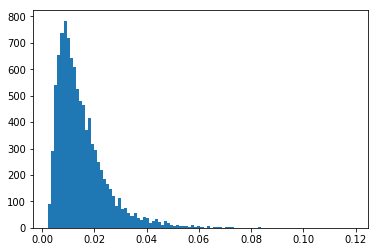

In [125]:
plt.hist(prediction3_3, bins=100 );

As we can probability is highly continuous in nature, this means that results are highly sensitive to any threshold we choose and susteble to error. This is therefore not a recommded algorithm

#### Choosing classifier - campaign_completed

Preparing dataset

In [126]:
trn_within_offer_period_and_completed_2_alt = trn_within_offer_period_and_completed_1[['person', 
                                                                                   'id_recd', 
                                                                                   'time_start', 
                                                                                   'campaign_completed']]

transaction_offer_relation_alt = pd.merge(transaction_transcript_merged_complete_grouped_1,
                                      trn_within_offer_period_and_completed_2_alt, 
                                      on = ['person', 'time_start'], 
                                      how='left')


transaction_offer_person_relation_alt = pd.merge(transaction_offer_relation_alt, 
                                             profile, 
                                             left_on='person', 
                                             right_on='id', 
                                             how='left')

transaction_offer_person_relation_1_alt = transaction_offer_person_relation_alt.query('age != 118').reset_index()


transaction_offer_person_relation_2_alt = transaction_offer_person_relation_1_alt.drop(columns=['person', 
                                                                                                'id_recd_x', 
                                                                                                'time_start',
                                                                                                'avg_transaction_amount',
                                                                                                'id_x',
                                                                                                'campaign_completed_y',
                                                                                                'id_recd_y',
                                                                                                'offer_viewed',
                                                                                                'became_member_on', 
                                                                                                'id_y', 
                                                                                                'channels',
                                                                                                'index'])

transaction_offer_person_relation_3_alt = pd.get_dummies(transaction_offer_person_relation_2_alt,
                                                     columns=['offer_type', 'gender'])


transaction_offer_person_relation_3_alt.campaign_completed_x.fillna(0, inplace=True)

In [127]:
transaction_offer_person_relation_3_alt.campaign_completed_x.value_counts(dropna=False)

0.0    48000
1.0    1629 
Name: campaign_completed_x, dtype: int64

In [128]:
X_alt = transaction_offer_person_relation_3_alt.drop(columns=['campaign_completed_x'])
Y_alt = transaction_offer_person_relation_3_alt['campaign_completed_x']

X_train_alt, X_test_alt, Y_train_alt, Y_test_alt = train_test_split(X_alt, Y_alt, random_state=42, test_size=0.2)

from sklearn.ensemble import RandomForestClassifier

# model_alt = RandomForestClassifier(n_estimators = 10, 
#                                min_samples_split = 10, min_samples_leaf = 5)
model_alt = LogisticRegression()
model_alt = model.fit(X_train_alt, Y_train_alt)
prediction_alt = model.predict(X_test_alt)

cm_alt = confusion_matrix(Y_test_alt, prediction_alt)
confusion_metrics(cm_alt)

True Positives: 0
True Negatives: 9595
False Positives: 1
False Negatives: 330
--------------------------------------------------
Accuracy: 0.9666532339
Mis-Classification: 0.03
Sensitivity: 0.0
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.0


Using LogisticRegression and predict 

In [129]:
model5 = LogisticRegression()
model5 = model5.fit(X_train_alt, Y_train_alt)
prediction5 = model5.predict(X_test_alt)
prediction5_1 = model5.predict_proba(X_test_alt)

cm = confusion_matrix(Y_test_alt, prediction5)
confusion_metrics(cm)

True Positives: 0
True Negatives: 9596
False Positives: 0
False Negatives: 330
--------------------------------------------------
Accuracy: 0.9667539794
Mis-Classification: 0.03
Sensitivity: 0.0
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.0


Using LogisticRegression and predict_proba

In [130]:
threshold = 0.01

prediction5_2 = np.empty_like(prediction5)
prediction5_3 = np.empty_like(prediction5)

for i in range(len(prediction5)):
    prediction5_3[i] = prediction5_1[i][1]
    
    if prediction5_1[i][1] > threshold:
        prediction5_2[i] = 1
    else:
        prediction5_2[i] = 0
        
cm = confusion_matrix(Y_test, prediction3_2)
confusion_metrics(cm)

True Positives: 136
True Negatives: 3463
False Positives: 6301
False Negatives: 26
--------------------------------------------------
Accuracy: 0.3625831151
Mis-Classification: 0.64
Sensitivity: 0.84
Specificity: 0.35
Precision: 0.35
f_1 Score: 0.5


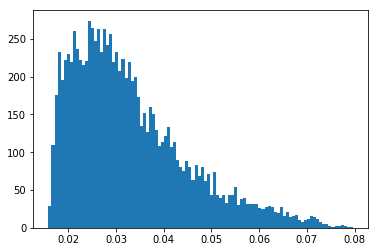

In [131]:
plt.hist(prediction5_3, bins=100 );

As we can probability is highly continuous in nature, this means that results are highly sensitive to any threshold we choose and susteble to error. This is therefore not a recommded algorithm

#### Outcome on Model Development and Recommendation

So far we have got unsatisfactory results on using ML to do any prediction.

This is because our data is highly unbalanced. Proportion of offer being successful or leading to increment in revenue is only 1.5% and offer completed within offer validity period is only 3%

We could look at gathering mode insights on user such as what kind of products customer like at Starbucks and offer them product based offers rather than generic offers like BOGO or discount. Since Starbucks mostly run on brick and mortar model which means most of sales happen in Starbucks store, there are chances that online offer does not really motivate customer to visit Starbucks store.

Another recommendation would be that Starbucks can take survey of customers who visit store to see if customer is really influenced by any offers or not. This would help Stabucks in 2 ways. One, if survey results say that customer does not really get annoyed with online offers, Starbucks can continue sending offers through online mode which would not impact customer experience. Second, if customer is not influenced by any offers, Starbucks can reduce amount of offer it sends online and save money as well resources on planning.

In next section, lets look at some meaningful information on the data and explore if we can use any insight to improve the model.

### Some useful insights

In [132]:
transaction_offer_person_relation_1.offer_success.fillna(0.0, inplace=True)
transaction_offer_person_relation_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49629 entries, 0 to 49628
Data columns (total 28 columns):
index                     49629 non-null int64
person                    49629 non-null object
id_recd_x                 49629 non-null object
duration                  49629 non-null float64
time_start                49629 non-null float64
campaign_completed        49629 non-null float64
offer_viewed              49629 non-null float64
difficulty                49629 non-null float64
reward                    49629 non-null float64
offer_type                49629 non-null object
avg_transaction_amount    49629 non-null float64
id_x                      49629 non-null object
channels                  49629 non-null object
email                     49629 non-null int64
mobile                    49629 non-null int64
social                    49629 non-null int64
web                       49629 non-null int64
avg_tran_amount           49629 non-null float64
tran_count              

Q1. What type of offers have higher success chances?

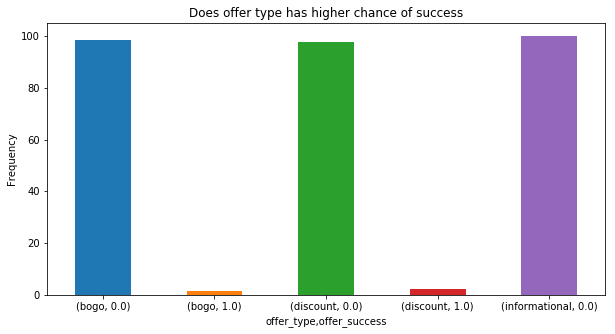

In [143]:
offer_type_success = transaction_offer_person_relation_1.groupby(['offer_type','offer_success'])['offer_type'].count() * 100 / transaction_offer_person_relation_1.groupby(['offer_type'])['offer_type'].count()
plt.figure(figsize=(10,5));
plt.title('Does offer type has higher chance of success')
plt.ylabel('Frequency')
offer_type_success.plot.bar(rot=0);

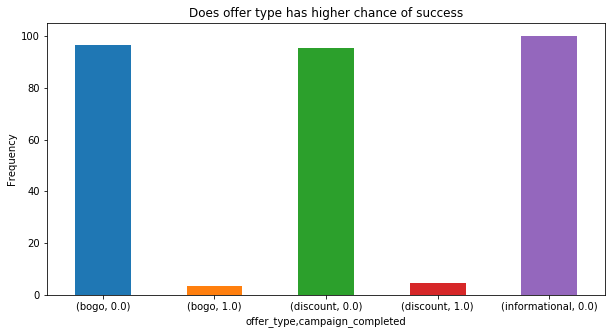

In [144]:
offer_type_campaign_completed = transaction_offer_person_relation_1.groupby(['offer_type','campaign_completed'])['offer_type'].count() * 100 / transaction_offer_person_relation_1.groupby(['offer_type'])['offer_type'].count()

offer_type_campaign_completed

plt.figure(figsize=(10,5));
plt.title('Does offer type has higher chance of success')
plt.ylabel('Frequency')
offer_type_campaign_completed.plot.bar(rot=0);

Offer Type does not seem to have high impact on Offer Success and Offer Completion

Q2. Does age has any impact on success chances?

In [135]:
print('for offer Success')
age_success = transaction_offer_person_relation_1.groupby(['offer_success'])['age'].mean() 
print(age_success)

print('\t')
print('for campaign completed')
age_campaign_completed = transaction_offer_person_relation_1.groupby(['campaign_completed'])['age'].mean() 
print(age_campaign_completed)

for offer Success
offer_success
0.0    53.740511
1.0    55.661376
Name: age, dtype: float64
	
for campaign completed
campaign_completed
0.0    53.687208
1.0    56.202578
Name: age, dtype: float64


Age also comes out to be insignificant different

Q3. Does income has any impact on success chances?

In [136]:
print('for offer Success')
income_success = transaction_offer_person_relation_1.groupby(['offer_success'])['income'].mean() 
print(income_success)

print('\t')
print('for campaign completed')
income_campaign_completed = transaction_offer_person_relation_1.groupby(['campaign_completed'])['income'].mean() 
print(income_campaign_completed)

for offer Success
offer_success
0.0    64109.385550
1.0    68525.132275
Name: income, dtype: float64
	
for campaign completed
campaign_completed
0.0    63933.895833
1.0    71329.650092
Name: income, dtype: float64


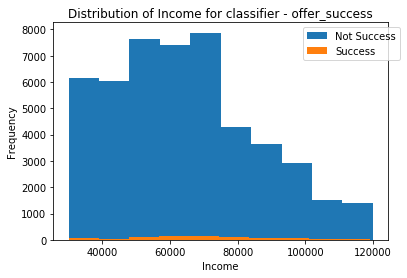

In [146]:
plt.hist(transaction_offer_person_relation_1.query('offer_success == 0').income, label='Not Success') 
plt.hist(transaction_offer_person_relation_1.query('offer_success == 1').income, label='Success');
plt.title('Distribution of Income for classifier - offer_success');
plt.xlabel('Income');
plt.ylabel('Frequency');
plt.legend(loc='best', bbox_to_anchor=(1.05, 1));

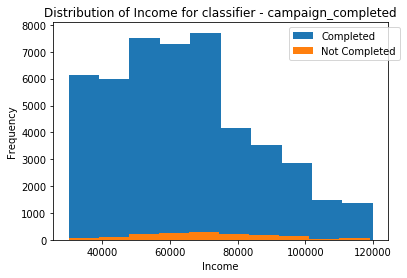

In [147]:
plt.hist(transaction_offer_person_relation_1.query('campaign_completed == 0').income, label='Completed');
plt.hist(transaction_offer_person_relation_1.query('campaign_completed == 1').income, label='Not Completed');
plt.title('Distribution of Income for classifier - campaign_completed');
plt.xlabel('Income');
plt.ylabel('Frequency');
plt.legend(loc='best', bbox_to_anchor=(1.05, 1));

Yes income does seems to have an impact. However the impact does not seem to be very different.

### Final Conclusion

So far we have not seen any significant difference in any feature which could have any high predicting power.

This is because our data is highly unbalanced. Proportion of offer being successful or leading to increment in revenue is only 1.5% and offer completed within offer validity period is only 3%

We could look at gathering mode insights on user such as what kind of products customer like at Starbucks and offer them product based offers rather than generic offers like BOGO or discount. Since Starbucks mostly run on brick and mortar model which means most of sales happen in Starbucks store, there are chances that online offer does not really motivate customer to visit Starbucks store.

Another recommendation would be that Starbucks can take survey of customers who visit store to see if customer is really influenced by any offers or not. This would help Stabucks in 2 ways. One, if survey results say that customer does not really get annoyed with online offers, Starbucks can continue sending offers through online mode which would not impact customer experience. Second, if customer is not influenced by any offers, Starbucks can reduce amount of offer it sends online and save money as well resources on planning.